<a href="https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/main/recipes/finetuning_dinov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to fine-tune DINOv2 for image classification



This tutorial shows how to use the [DINOv2](https://dinov2.metademolab.com/) self-supervised vision transformer model to generate pre-annotations on a defect detection use case.

Modern foundation models (FMs) are capable of performing many diverse tasks; large language models can quickly and accurately process natural language while models focused on image processing are very good at computer vision tasks, such as object detection or classification.

By retraining an FM on a very limited set of examples, it is possible to even further improve its performance on a specific task, such as image classification. This process is called fine-tuning.

Throughout this tutorial, we will:

- Configure a project on Kili.
- Fine-tune the DINOv2 model using a tiny set of labeled images on Kili.
- Generate pre-annotations on a set of images to label.
- Evaluate the quality of the generated pre-annotations in the Kili interface.


## Setup

Let's first install the Kili package and all other packages required for our experiment:

In [1]:
%pip install kili matplotlib numpy Pillow scikit-learn torch torchvision kaggle tqdm

In [ ]:
import os
import random
import zipfile
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sklearn.metrics import classification_report
from torch import nn, optim
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from kili.client import Kili

To interact with Kili using the Python SDK, it is necessary to have a Kili account and an API key.

In [ ]:
kili = Kili(
    # api_endpoint="https://cloud.kili-technology.com/api/label/v2/graphql",
    # the line above can be uncommented and changed if you are working with an on-premise version of Kili
)

## Kili project configuration

In this section, we will create a project from scratch with existing labels on Kili.

If you want to use your own project, you can simply skip this section and replace the `project_id` variable by your own project ID.

### Download assets & create project

For this tutorial, we will use a real-life image dataset of products created through the process of casting from Kaggle. You can download it from [here](https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product).

We will use the Kaggle API to download the dataset.

In [ ]:
path_to_kaggle_api_key = Path.home() / ".kaggle" / "kaggle.json"

if not path_to_kaggle_api_key.is_file():
    json_key_str = getpass.getpass("Enter your kaggle json api key: ")
    path_to_kaggle_api_key.parent.mkdir(parents=True, exist_ok=True)
    path_to_kaggle_api_key.write_text(json_key_str)

In [ ]:
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

Once the .zip file is downloaded, we can unzip it and discover the structure of the dataset:

In [ ]:
with zipfile.ZipFile("real-life-industrial-dataset-of-casting-product.zip", "r") as zip_ref:
    zip_ref.extractall(".")

We can see that the dataset has two classes of images: `ok_front` and `def_front`. `ok_front` images are images of products without defects, and `def_front` images are images of products with defects.

In [ ]:
data_dir = Path() / "casting_512x512" / "casting_512x512"
print(os.listdir(data_dir))
print(len(os.listdir(data_dir / "def_front")))
print(len(os.listdir(data_dir / "ok_front")))

['ok_front', 'def_front']
781
519


The `ok_front` class has 519 images, and the `def_front` class has 781 images.

Let's take a look at the images:

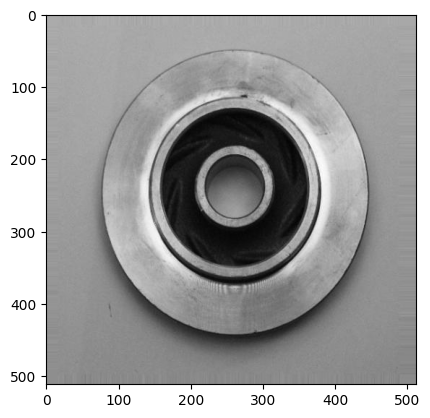

In [ ]:
plt.imshow(Image.open(next((data_dir / "def_front").iterdir())))
plt.show()

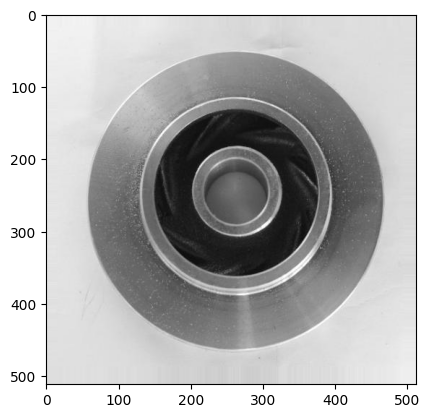

In [ ]:
plt.imshow(Image.open(next((data_dir / "ok_front").iterdir())))
plt.show()

We can balance the dataset and keep only `N` images in total:

In [ ]:
N = 400

for class_name in ["def_front", "ok_front"]:
    filepaths_to_delete = sorted(os.listdir(data_dir / class_name))[N // 2 :]
    for filepath in filepaths_to_delete:
        (data_dir / class_name / filepath).unlink(missing_ok=True)

assert len(os.listdir(data_dir / "def_front")) == N // 2
assert len(os.listdir(data_dir / "ok_front")) == N // 2

Next, we create the Kili project with its ontology showing the two categories:

In [ ]:
project_title = "[Kili SDK Notebook]: Demo - DINOv2 Classification"

json_interface = {
    "jobs": {
        "CLASSIFICATION_JOB": {
            "content": {
                "categories": {
                    "YES": {"children": [], "name": "Yes", "id": "category1"},
                    "NO": {"children": [], "name": "No", "id": "category2"},
                },
                "input": "radio",
            },
            "instruction": "Defect(s) in image?",
            "mlTask": "CLASSIFICATION",
            "required": 1,
            "isChild": False,
            "isNew": False,
        }
    }
}

project_id = kili.create_project(
    title=project_title, json_interface=json_interface, input_type="IMAGE"
)["id"]

We can then prepare the assets to be uploaded to Kili:

In [ ]:
# sort the assets by alternating between classes so that both
# classes show up in the first page of the labeling interface
content_array = []
iterator = zip((data_dir / "def_front").iterdir(), (data_dir / "ok_front").iterdir())
for filepath_def, filepath_ok in iterator:
    content_array.append(filepath_def)
    content_array.append(filepath_ok)
print(content_array[0])

casting_512x512/casting_512x512/def_front/cast_def_0_1145.jpeg


The external ID of each asset is the name of the image displayed in the Kili interface:

In [ ]:
external_id_array = []
for filepath in content_array:
    class_ = "def" if "_def_" in filepath.name else "ok"
    external_id = filepath.name.replace("cast_ok_0_", "").replace("cast_def_0_", "")
    external_id = external_id.replace(".jpeg", "_" + class_[:1])
    external_id_array.append(external_id)
assert len(set(external_id_array)) == N
print(external_id_array[0])

1145_d


The class of an image is available in the file name. We can extract it and add it to the Kili asset metadata:


In [ ]:
output_class_array = ["YES" if "def" in filepath.name else "NO" for filepath in content_array]
print(output_class_array[0])

YES


We input the ground truth in the metadata, this will be useful later on:

In [ ]:
json_metadata_array = [{"Ground Truth": output_class} for output_class in output_class_array]
print(json_metadata_array[0])

{'Ground Truth': 'YES'}


We now upload the assets to our Kili project:

In [ ]:
kili.append_many_to_dataset(
    project_id=project_id,
    external_id_array=external_id_array,
    content_array=[str(x) for x in content_array],
    json_metadata_array=json_metadata_array,
)

### Import annotations

In this tutorial, we will need to use ground truth annotations to fine-tune the DINOv2 model.

We thus simulate manual labeling on some images.

In [ ]:
nb_manually_labeled_assets = 200

In [ ]:
json_response_array = [
    {"CLASSIFICATION_JOB": {"categories": [{"confidence": 100, "name": output_class}]}}
    for output_class in output_class_array
]

In [ ]:
kili.append_labels(
    project_id=project_id,
    asset_external_id_array=external_id_array[:nb_manually_labeled_assets],
    json_response_array=json_response_array[:nb_manually_labeled_assets],
    label_type="DEFAULT",
    seconds_to_label_array=[
        random.randint(60, 300)
        for _ in range(nb_manually_labeled_assets)  # simulate labeling time
    ],
)

# Replace the project_id below with your own project_id!
print(f"\nAccess your project at: https://cloud.kili-technology.com/label/projects/{project_id}")

100%|██████████| 200/200 [00:24<00:00,  8.28it/s]


Access your project at: https://cloud.kili-technology.com/label/projects/cliistnwa003c0j78ay1y3qlm


![image.png](attachment:febc8688-2d45-48f6-acb7-1a400db2f5fc.png)

Now we have a configured project on our Kili organization, with some assets already manually labeled.

## Model training

In this section, we will fine-tune the DINOv2 model using labeled images from a Kili project.

### Dataset preparation

Here, we will use the project we created earlier, but feel free to use your own project:

In [ ]:
project_id = project_id  # put your own Kili project id here

In [ ]:
nb_labeled_assets = 200  # put the number of labeled assets you want to retrieve here

In [ ]:
data_dir = "./data"

labeled_assets = kili.assets(
    project_id=project_id,
    fields=[
        "id",
        "content",
        "labels.jsonResponse",
        "externalId",
        "latestLabel.jsonResponse",
        "jsonMetadata",
    ],
    status_in=["LABELED"],  # we retrieve assets already labeled
    download_media=True,
    local_media_dir=data_dir,
    first=nb_labeled_assets,
    label_output_format="parsed_label",
)

print(f"\nRetrieved {len(labeled_assets)} labeled assets.")

100%|██████████| 200/200 [00:26<00:00,  7.57it/s]


Retrieved 200 labeled assets.


We split the train data into the two classes:

In [ ]:
Path("./data/train/YES").mkdir(parents=True, exist_ok=True)
Path("./data/train/NO").mkdir(parents=True, exist_ok=True)

for asset in labeled_assets:
    class_name = asset["latestLabel"].jobs["CLASSIFICATION_JOB"].category.name
    filepath = Path(asset["content"])
    filepath.rename(filepath.parent / "train" / class_name / filepath.name)

print(os.listdir(data_dir))
print(len(os.listdir(data_dir + "/train/YES")))
print(len(os.listdir(data_dir + "/train/NO")))

['train']
100
100


Below, we prepare the pipeline that loads the images and applies some data augmentation. Data augmentation is a technique that consists of applying random transformations to the images to artificially increase the size of the dataset. This technique is very useful when the dataset is small, since it allows the model to see more images during training.

For example, we can apply random horizontal and vertical flips and random rotations to the images:

In [ ]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(224),
            transforms.RandomRotation(360),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

image_datasets = {
    "train": datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
}

dataloaders = {
    "train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=8, shuffle=True)
}

class_names = image_datasets["train"].classes

print(class_names)

['NO', 'YES']


### Model download & fine-tuning


We load the DINOv2 model from the HuggingFace library:

In [ ]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

Let's see what is the output of this model:

In [ ]:
input_img_tensor, class_id = next(iter(image_datasets["train"]))

with torch.inference_mode():
    output = dinov2_vits14(torch.unsqueeze(input_img_tensor, dim=0))

print(output.size())

torch.Size([1, 384])


As you can see, the output is a vector of dimension 384. This is the embedding of the image.

The embedding is a vector that represents the image in the DINOv2 model latent space. The embedding contains a compressed representation of the image, which is useful for many tasks, such as image classification.

The embedding dimension is:

- 384 for ViT-S (we are using this model in this tutorial).
- 768 for ViT-B.
- 1024 for ViT-L.
- 1536 for ViT-g.


To predict a class, we need to add a classification head to the DINOv2 model.

This small neural network will take the embeddings as input, and will output a score for the binary classification.

In [ ]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = deepcopy(dinov2_vits14)
        self.classifier = nn.Sequential(nn.Linear(384, 256), nn.ReLU(), nn.Linear(256, 1))

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x


model = DinoVisionTransformerClassifier()

Below, we select the device to use for training. It is recommended to use a GPU for this task:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model = model.to(device)
model = model.train()

Device:  cuda:0


We use a binary cross-entropy loss to train the model, with the Adam optimizer.

The binary cross-entropy loss is a standard loss function for binary classification tasks. The loss is like the error between the predicted class and the ground truth class. The higher the loss, the worse the model is.

To decrease the loss, we will use the Adam optimizer, which is a widely used optimizer for neural networks. It is a stochastic gradient descent method that computes adaptive learning rates for each parameter of the model.

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

We also define the number of epochs to train the model. An epoch is a full pass through the training data.

In [ ]:
num_epochs = 15

In [ ]:
epoch_losses = []
for epoch in range(num_epochs):
    print("Epoch: ", epoch)

    batch_losses = []
    for data in dataloaders["train"]:
        # get the input batch and the labels
        batch_of_images, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # model prediction
        output = model(batch_of_images.to(device)).squeeze(dim=1)

        # compute loss and do gradient descent
        loss = criterion(output, labels.float().to(device))
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    epoch_losses.append(np.mean(batch_losses))
    print(f"Mean epoch loss: {epoch_losses[-1]}")

print("Finished training!")

Epoch:  0
Mean epoch loss: 0.7347773921489715
Epoch:  1
Mean epoch loss: 0.5930992090702056
Epoch:  2
Mean epoch loss: 0.5117795491218566
Epoch:  3
Mean epoch loss: 0.4436239504814148
Epoch:  4
Mean epoch loss: 0.34697133481502535
Epoch:  5
Mean epoch loss: 0.2919022357463837
Epoch:  6
Mean epoch loss: 0.18035753384232522
Epoch:  7
Mean epoch loss: 0.117118861079216
Epoch:  8
Mean epoch loss: 0.11755006849765777
Epoch:  9
Mean epoch loss: 0.08585118860006333
Epoch:  10
Mean epoch loss: 0.07716833263635635
Epoch:  11
Mean epoch loss: 0.05035351105034351
Epoch:  12
Mean epoch loss: 0.06317368872463704
Epoch:  13
Mean epoch loss: 0.04912809677422047
Epoch:  14
Mean epoch loss: 0.05099196014925837
Finished training!


As you can see on the plot below, the loss decreases as the number of epochs increases. This means that the model has successfully learned to classify images.

When the loss stops decreasing, it means that the model has converged and that we can stop the training. In this case, we could have stopped the training after 11 epochs.

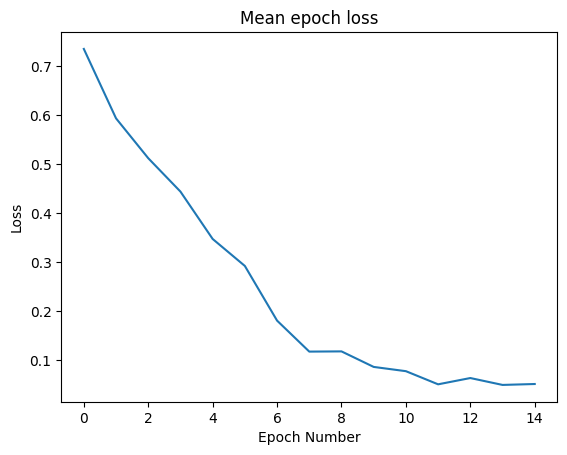

In [ ]:
plt.plot(epoch_losses)
plt.title("Mean epoch loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

Perfect! The model is now fine-tuned on the labeled images from Kili.

## Predict with the model on unlabeled assets

In this section, we will use the fine-tuned model to generate pre-annotations on a set of images to label.

In [ ]:
max_nb_assets_to_label = 200

In [ ]:
non_labeled_assets = kili.assets(
    project_id=project_id,
    fields=["id", "content", "externalId", "jsonMetadata"],
    status_in=["TODO"],  # we choose assets to label
    first=max_nb_assets_to_label,
    download_media=True,
)
print("\nNumber of fetched assets to label: ", len(non_labeled_assets))

100%|██████████| 200/200 [00:18<00:00, 11.08it/s]


Number of fetched assets to label:  200


The `kili.assets` method returns a list of assets represented as Python dictionaries:

In [ ]:
non_labeled_assets[0]

{'id': 'cliisunn100xcmkp9tsuj17ut',
 'content': '/root/.cache/kili/projects/cliistnwa003c0j78ay1y3qlm/assets/3016_d.jpg',
 'externalId': '3016_d',
 'jsonMetadata': {'Ground Truth': 'YES'}}

We can now use the model to generate pre-annotations on the assets:

In [ ]:
data_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

We switch the model to evaluation mode since we don't want to update the weights of the model anymore:

In [ ]:
model = model.eval()

In [ ]:
external_id_array_non_labeled_assets = []
y_true_non_labeled_assets = []
embeddings_non_labeled_assets = []
y_pred_dinov2_non_labeled_assets = []
json_response_array_non_labeled_assets = []

for asset in tqdm(non_labeled_assets):
    external_id_array_non_labeled_assets.append(asset["externalId"])
    y_true_non_labeled_assets.append(asset["jsonMetadata"]["Ground Truth"])

    img = Image.open(asset["content"])

    img_tensor = data_transforms(img)
    img_tensor = img_tensor.unsqueeze(0)
    input_tensor = img_tensor.to(device)

    # Perform inference
    with torch.no_grad():
        embeddings = model.transformer(input_tensor)
        embeddings_non_labeled_assets.append(embeddings[0].cpu().numpy())
        x = model.transformer.norm(embeddings)
        output_tensor = model.classifier(x)

    score = output_tensor[0][0].item()

    score = 1 / (1 + np.exp(-score))  # sigmoid

    output_class = "YES" if score > 0.5 else "NO"

    y_pred_dinov2_non_labeled_assets.append(output_class)

    json_response_array_non_labeled_assets.append(
        {
            "CLASSIFICATION_JOB": {
                "categories": [{"confidence": int(round(score * 100)), "name": output_class}]
            }
        }
    )

We now push the predictions to Kili as pre-annotations (prediction) and inference labels.

The pre-annotations will be helpful for the labelers to label the assets, since those pre-annotations will be displayed in the Kili interface. It will help them to label the assets faster.

The inference labels will be used to evaluate the quality of the model against labelers.

You can learn more about the different kinds of labels in the [Kili documentation](https://docs.kili-technology.com/docs/asset-lifecycle).

In [ ]:
kili.append_labels(
    project_id=project_id,
    json_response_array=json_response_array_non_labeled_assets,
    model_name="DINOv2",
    label_type="INFERENCE",
    asset_external_id_array=external_id_array_non_labeled_assets,
)

kili.append_labels(
    project_id=project_id,
    json_response_array=json_response_array_non_labeled_assets,
    model_name="DINOv2",
    label_type="PREDICTION",
    asset_external_id_array=external_id_array_non_labeled_assets,
)

## Pre-annotations quality analysis


### Finetuning with DINOv2

In [ ]:
print(classification_report(y_true_non_labeled_assets, y_pred_dinov2_non_labeled_assets))

              precision    recall  f1-score   support

          NO       0.97      0.94      0.95       100
         YES       0.94      0.97      0.96       100

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



We get an accuracy of ~95% for the fine-tuned DINOv2 model on a binary classification task.

### K-nearest neighbors

We can also use the embeddings directly to find the nearest neighbors of an image, and use the class of the nearest neighbors as the predicted class.

This method has the advantage of not requiring to fine-tune the model.

It however takes some time to pre-compute the embeddings of all the images in the dataset.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)

In [ ]:
dinov2_vits14 = dinov2_vits14.to(device)

In [ ]:
embeddings_labeled_assets = []
y_true_training_knn = []

for asset in tqdm(labeled_assets):
    class_name = asset["jsonMetadata"]["Ground Truth"]
    y_true_training_knn.append(class_name)

    filepath = asset["content"].replace("/data/", "/data/train/" + class_name + "/")
    img = Image.open(filepath)
    img_tensor = data_transforms(img)
    img_tensor = img_tensor.unsqueeze(0)
    input_tensor = img_tensor.to(device)

    with torch.no_grad():
        output_tensor = dinov2_vits14(input_tensor)
    embeddings_labeled_assets.append(output_tensor[0].cpu().numpy())

neigh.fit(embeddings_labeled_assets, y_true_training_knn)

In [ ]:
y_pred_knn = neigh.predict(embeddings_non_labeled_assets)

In [ ]:
print(classification_report(y_true_non_labeled_assets, y_pred_knn))

              precision    recall  f1-score   support

          NO       0.91      0.84      0.87       100
         YES       0.85      0.92      0.88       100

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



As you can see, the accuracy is lower than with the fine-tuned model.

## Upload more manual annotations

In the section above, we uploaded model-made annotations on the non-labeled assets to Kili.

Now, we simulate manual labeling on the non-labeled assets:

In [ ]:
gt_external_id_array = []
gt_json_response_array = []

for asset in non_labeled_assets:
    gt_external_id_array.append(asset["externalId"])
    gt_json_response_array.append(
        {
            "CLASSIFICATION_JOB": {
                "categories": [{"confidence": 100, "name": asset["jsonMetadata"]["Ground Truth"]}]
            }
        }
    )

In [ ]:
kili.append_labels(
    project_id=project_id,
    asset_external_id_array=gt_external_id_array,
    json_response_array=gt_json_response_array,
    label_type="DEFAULT",
)

In the Kili interface, we can filter the assets based on the disagreements between human-made labels and DINOv2-generated labels:

In [ ]:
# replace the project id below with your own!
print(
    f"https://cloud.kili-technology.com/label/projects/{project_id}/explore?inferenceMarkGte=0&inferenceMarkLte=0.75"
)

https://cloud.kili-technology.com/label/projects/cliistnwa003c0j78ay1y3qlm/explore?inferenceMarkGte=0&inferenceMarkLte=0.75


![image.png](attachment:8d64f1c1-7b24-43b2-8f34-98180dcf43e7.png)

In the image above, we can see that the DINOv2 prediction has classified this asset as a negative sample, when it should have been classified as a positive sample.

## Conclusion

In this tutorial, we have seen how to fine-tune the DINOv2 model on a very small set of labeled images, and how to use the fine-tuned model to generate pre-annotations on a set of images to label.

We have also seen how to evaluate the quality of the generated pre-annotations, and how to use them to speed up the labeling process.

## Clean up

We can now delete the project we created on Kili:

In [ ]:
kili.delete_project(project_id=project_id)